# Programing exercise 9: Linblad master equation, EIT

Due on Monday, 14.01.2019, 14.15h

__This exercise sheet has been solved by:__ Mathieu Kaltschmidt and Carl von Randow

### Total: 100 points

## The problem

Light propagating through an atomic medium is usually scattered and thus absorbed thorough near-resonant coupling to a transition from the ground ($|g_1\rangle$) to an excited ($|e\rangle$) electronic state. If a second light field ("coupling laser") couples the excited state to a third, long-lived, state ($|g_2\rangle$), the medium can again become transparent for the first light field ("probe laser"). This effect, called electromagnetically induced transparency (EIT) - the above description referring to the lambda confuration for obvious reasons - has led to a plethora of applications, see e.g. Rev. Mod. Phys. 77, 633 (2005) [1]. The dynamics of the atomic populations can be simulated using the Lindbald master equation approach, accounting for the coherent driving laser fields, and incoherent processes such as spontaneous emission and dephasing, e.g. due to finite laser linewidth. The complex refractive index of the atomic medium is given by $n=\sqrt{1+\chi}\approx 1 + (\chi_R + \chi_I)/2$, where the real and imaginary part of complex  susceptibility $\chi$ account for diffraction and absorption of the probe light respectively. $\chi$ depends on the polarizability of the atomic dipoles in the medium and is thus proportional to expectation value of the operator $|g_1\rangle \langle e|$, i.e. $\rm{tr}[|g_1\rangle \langle e| \rho] = \langle e| \rho |g_1 \rangle = \rho_{eg_1}$. This coherence will thus be the main object of interest.

The interaction with the laser fields is described by the Hamiltonian (in rotating wave approximation, in the basis $\{|g_1\rangle,|g_2\rangle,|e\rangle\}$, following the sign convention used in [1])
$$
H=\left[
\begin{array}{ccc}
0 & 0 & -\Omega_p/2 \\
0 & \Delta_p-\Delta_c & -\Omega_c/2 \\
-\Omega_p/2 & -\Omega_c/2 & \Delta_p
\end{array}
\right]
$$
where $\Omega$'s are Rabi-frequencies and $\Delta$'s are the detunings of the lasers from the respective atomic transitions. $\Delta_p-\Delta_c$ is the "two-photon-detuning" sometimes abbreviated as $\delta_2$.

The dissipative processes we want to consider are the spontaneous emission from $e$ to both ground states $g_1$ and $g_2$ and later also the decay from $g_2$ to $g_1$, which breaks the EIT. These are accouted for by the jump operators
$$
\Gamma_{eg_1} = \sqrt{\gamma_p} |g_1\rangle \langle e|, \quad \Gamma_{eg_2} = \sqrt{\gamma_c} |g_2\rangle \langle e|, \quad\Gamma_{g_2g_1} = \sqrt{\gamma_g} |g_1\rangle \langle g_2| .
$$
The resulting master equation reads
$$
\dot\rho = -i[H,\rho] + \mathcal{L}_{\Gamma_{eg_1}} [\rho]+ \mathcal{L}_{\Gamma_{eg_2}} [\rho]+ \mathcal{L}_{\Gamma_{g_2g_1}} [\rho]
$$
with the Lindblad superoperator
$$
\mathcal{L}_{\Gamma_x} [\rho] = \Gamma_x \rho \Gamma_x^\dagger - \frac{1}{2}(\Gamma_x^\dagger\Gamma_x \rho + \rho \Gamma_x^\dagger\Gamma_x)
$$

In [1]:
#Importing useful libraries
import numpy as np   
import numpy.linalg as LA
import matplotlib.pyplot as plt 
%matplotlib inline
from copy import deepcopy

#Plot settings
plt.style.use('seaborn-talk')
plt.rcParams["font.family"]='serif'
plt.rcParams["figure.figsize"][0] = 14
plt.rcParams["figure.figsize"][1] = 9

### Exercise 1 (40 points)

Set up the Liouvillian matrix. Check your implementation by calculating the steady state for the case of zero two-photon detuning (and $\gamma_{g}=0$), where the steady state is the pure state ("dark state")
$$
|d\rangle = \frac{\Omega_c |g_1\rangle - \Omega_p |g_2\rangle}{\sqrt{\Omega_p^2 + \Omega_c^2}}.
$$

Detailed instructions (You can of course proceed differently if you want. I am pretty sure the method described in the following is not the most elegant one...):
- Building the Liouvillian in matrix form: We want to formulate the master equation in the standard form of an ordinary differnetial equation $\dot\rho = \mathcal{L} \rho$ with $\rho$ the density matrix in vector form and $\mathcal{L}$ a matrix summarizing the right hand side of the master equation. However, the master equation is more conveniently formulated using dot-products between matrices representing operators in Hilbert space. Therefore, it is makes sense to write a function that takes the vectorized density matrix as an input (along with the Hamiltonian matrix and the jump operators used in the Lindblad terms), converts it into a matrix using reshape() calculates the right hand side of the master equation and returns the result in vector form by using reshape again. To build the Liouvillian matrix you can pass all the projectors $|i\rangle\langle j|$ to this function. Those are the unitvectors spanning the space of vectorized density matrices. The outputs will be the columns of the Liouvillian matrix.
- Calculating steady states: The steady state is the unique state for which the right hand side of the master equation gives zero. Calculating this is less trivial than it seems. If we just try solving the linear system of equations $\mathcal{L}\rho = 0$ it wont work since $\rho=0$ is always a trivial solution. We need to ensure that the trace of the density matric is 1. This can be achieved by dropping the first line of the master equation ($\dot\rho_{g_1g_1}=...$) and replacing $\rho_{g_1g_1} = 1-\rho_{g_2g_2}-\rho_{ee}$ everywhere. The resulting inhomogeneous system of 8 equations can be solved using np.linalg.solve(). $\rho_{g_1g_1}$ can be prepended to the solution by using the trace condition again. There are many other ways to calculate steady states, see for example the qutip documentation (http://qutip.org/docs/4.0.2/guide/guide-steady.html). You can of course also use qutip routines to check your results.

### First part: Setting up the Liouvillian and the master equation

In [2]:
#Some parameters
(gamma_p, gamma_c, gamma_g) = (1, 1, 0)

#states of our system [g1,g2,e]
states = {'g1': np.diag(np.ones(3))[0], \
          'g2': np.diag(np.ones(3))[1], \
          'e':  np.diag(np.ones(3))[2] } 

#definining the jump operators
def buildJumpOps(gamma_p, gamma_c, gamma_g):
    JumpOps = {'eg1':  np.sqrt(gamma_p) * np.outer(states['g1'], states['e']), \
               'eg2':  np.sqrt(gamma_c) * np.outer(states['g2'], states['e']), \
               'g1g2': np.sqrt(gamma_g) * np.outer(states['g2'], states['g1']) }
    return JumpOps

#Building the Hamiltonian
def buildHmat(Omega_p, Omega_c, Delta_p, Delta_c):
    Hmat = np.array([[0, 0, -Omega_p/2], [0, Delta_p - Delta_c, -Omega_c/2], [-Omega_p/2, -Omega_c/2, Delta_p]])
    return Hmat

#Formulating the master equation
def MasterEqn(rho, Hmat, Gammas):
    """
    Input:
    rho = vectorized density matrix
    HMat = Hamiltonian as 3x3 matrix 
    Gammas = jump operators appearing in the Lindblad equation
    
    Output:
    columns of the Liouvillian matrix
    """
    
    #Correct reshaping 
    rho = np.reshape(rho, (3,3))
    #First term of the master equation
    rhs = -1j*(Hmat@rho - rho@Hmat)
    #Building the Lindblad superoperators
    for JumpOp in Gammas.values():
        rhs += JumpOp@rho@np.transpose(JumpOp) - (np.transpose(JumpOp)@JumpOp@rho + rho@np.transpose(JumpOp)@JumpOp)/2
    
    #Correct reshaping    
    rhs = np.reshape(rhs, (9))   
    return rhs

In [3]:
def Liouvillian(Hmat, Gammas):
    L = np.zeros((9,9), dtype = complex) 
    for i in range(9):
        rho_i = np.zeros(9)
        rho_i[i] = 1 
        L[:, i] = MasterEqn(rho_i, Hmat, Gammas)
    return L

### Second part: Calculating the steady state

In [4]:
def steady_state(L):
    A = deepcopy(L[1:,1:])
    col = L[1:,0]
    
    for i in range(len(col)):
        A[i, 3] -= col[i]
        A[i, 7] -= col[i]

    x = LA.solve(A, -col)
    
    steady = np.zeros(len(x)+1, dtype = complex)
    steady[1:] = x
    steady[0] = 1 - steady[4] - steady[8]
    return steady

### Comparing our calculation with the given dark state

In [5]:
#Arbitrary parameters but Delta_p - Delta_c needs to be zero, see conditions!
(Omega_p, Omega_c, Delta_p, Delta_c) = (1, 1, 1, 1)

#Calculation the steady state
L = Liouvillian(buildHmat(Omega_p, Omega_c, Delta_p, Delta_c), buildJumpOps(gamma_p, gamma_c, gamma_g))
steady = steady_state(L)

print('The calculated steady state is:')
print(np.reshape(steady, (3,3)))
print()

print('Diagonalizing givs the following eigenvectors (= states):')
print(LA.eig(np.reshape(steady, (3,3)))[1])
print()


dark_state = (Omega_c * states['g1'] - Omega_p * states['g2']) / np.sqrt(Omega_p**2 + Omega_c**2)
print('The theoretical dark state is', dark_state)

The calculated steady state is:
[[ 0.5+0.j -0.5+0.j  0.0+0.j]
 [-0.5+0.j  0.5+0.j  0.0-0.j]
 [ 0.0+0.j  0.0-0.j  0.0+0.j]]

Diagonalizing givs the following eigenvectors (= states):
[[ 0.70710678+0.j  0.70710678+0.j  0.00000000+0.j]
 [-0.70710678+0.j  0.70710678+0.j  0.00000000+0.j]
 [ 0.00000000+0.j  0.00000000+0.j  1.00000000+0.j]]

The theoretical dark state is [ 0.70710678 -0.70710678  0.        ]


### Discussion:

The second eigenstate of our calculated steady state represents the state we would expect from theory, but with reversed minus signs.

### Exercise 2 (20 points)

Scan the probe detuning $\Delta_p$ at resonant coupling beam ($\Delta_c=0$). Plot imaginary and real part of the steady state $\rho_{eg_1}$ as a function of $\Delta_p$. Start with parameters $\Omega_p=\Omega_c=\gamma_p=1$ and all other parameters zero. You should see the charactersitic EIT dip in the absorption (see Fig. 1 in [1]). Then change the coupling Rabi frequency to a larger value to see what happens (Fig. 7 in [1]). Can you interpret the result in the dressed-state picture? Also change $\gamma_p$ and $\gamma_c$ and describe your observation. In principle, $\gamma_p$ can be set to 1, defining the energy scale. In this exercise the focus is on exploring the physics of the problem and interpreting the numerical results.

### Detuning $\Delta_p$ at resonant coupling

In [6]:
#Definition of some parameters
(gamma_p, gamma_c, gamma_g) = (1, 0, 0)

(Delta_p, Delta_c) = (np.linspace(-3,3,100), 0)

(Omega_p, Omega_c) = (1, 1)

#Calculating the Liouvillian and the needed component of the steady state
steady_real = []
steady_imag = []
for value in Delta_p:
    L = Liouvillian(buildHmat(Omega_p, Omega_c, value, Delta_c), buildJumpOps(gamma_p, gamma_c, gamma_g))
    #eg1 component of the steady state
    steady = steady_state(L)[6] 
    steady_real.append(steady.real)
    steady_imag.append(steady.imag)

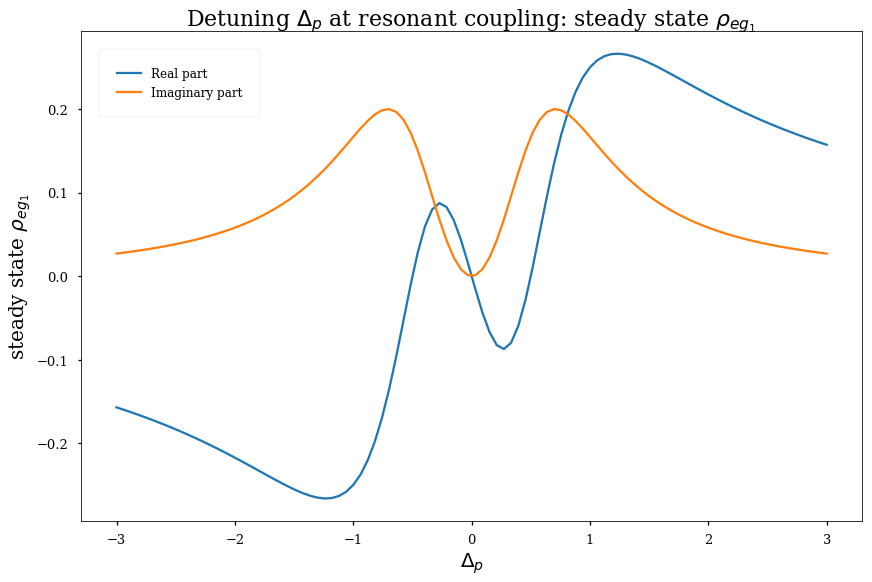

In [7]:
#Plotting the results
plt.plot(Delta_p, steady_real, label = 'Real part')
plt.plot(Delta_p, steady_imag, label = 'Imaginary part')

plt.title(r'Detuning $\Delta_p$ at resonant coupling: steady state $\rho_{eg_1}$', size = 22)
plt.xlabel(r'$\Delta_p$', size = 20)
plt.ylabel(r'steady state $\rho_{eg_1}$', size = 20)
plt.legend(frameon=True,fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')

### Interpretation:

We found the same result as observed in the corresponding paper, except that the real part has a different sign which can be explained by the fact, that we maybe chose other signs conventions.

### Changing the coupling Rabi frequency

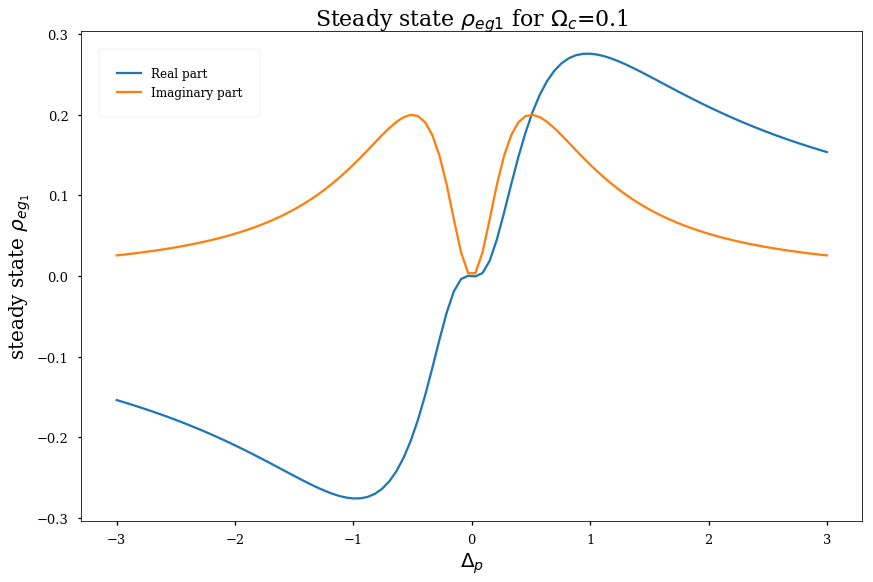

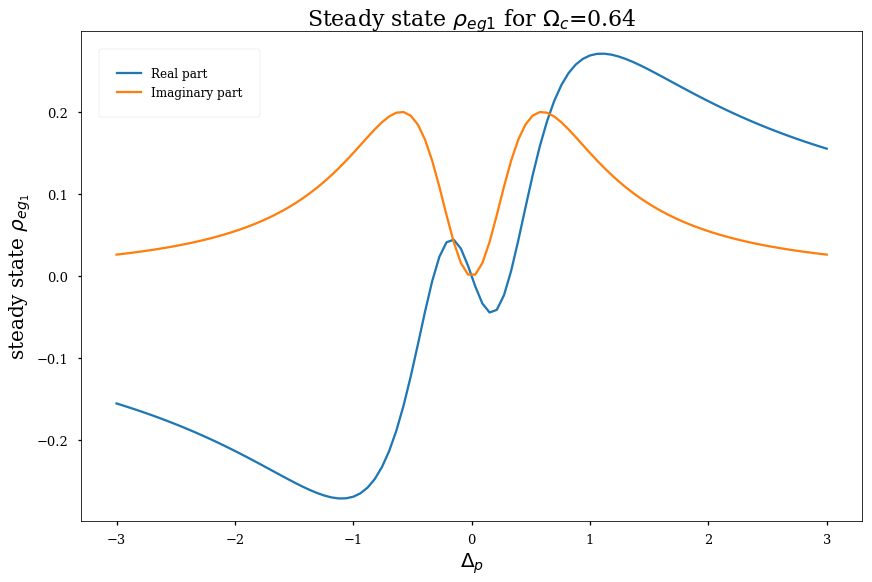

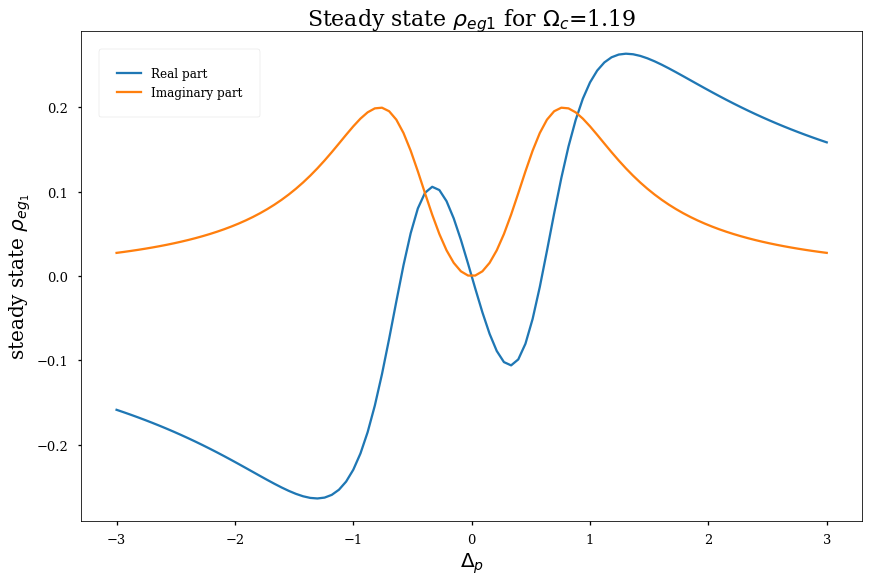

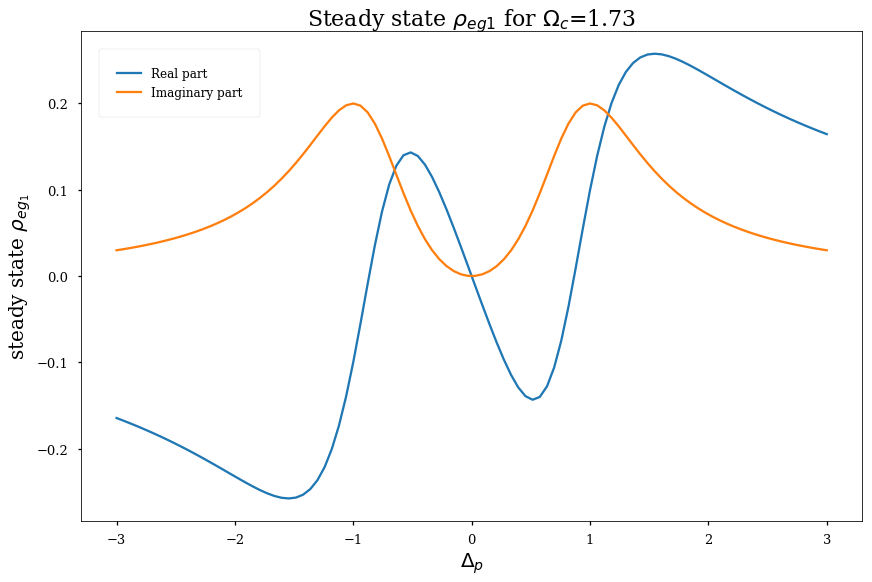

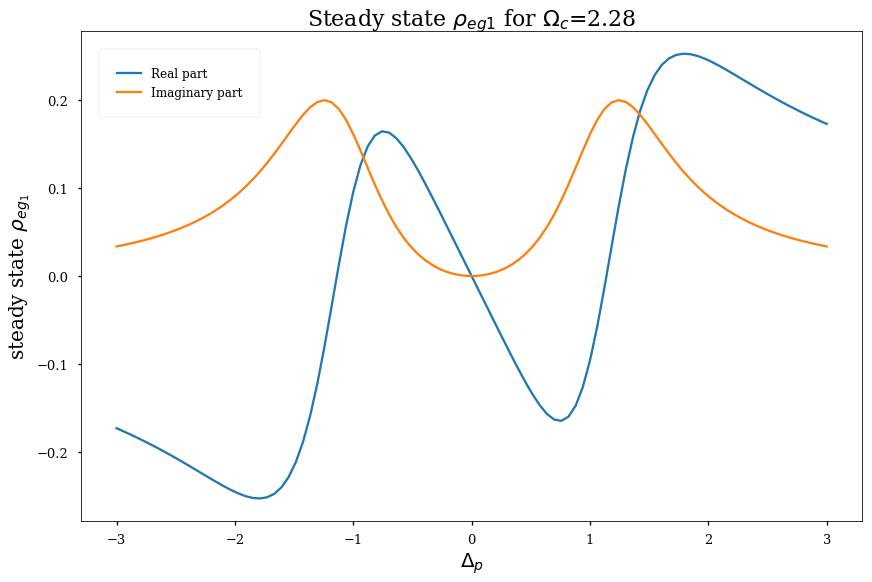

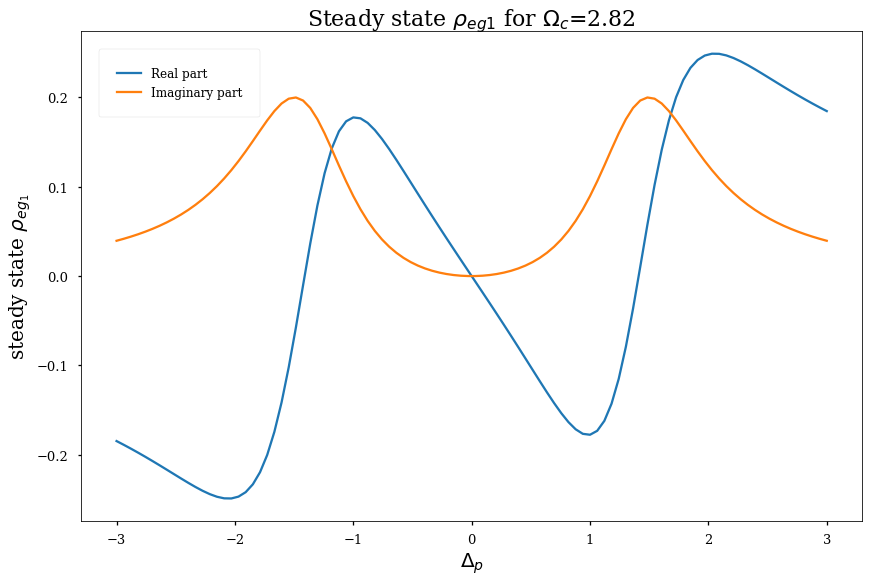

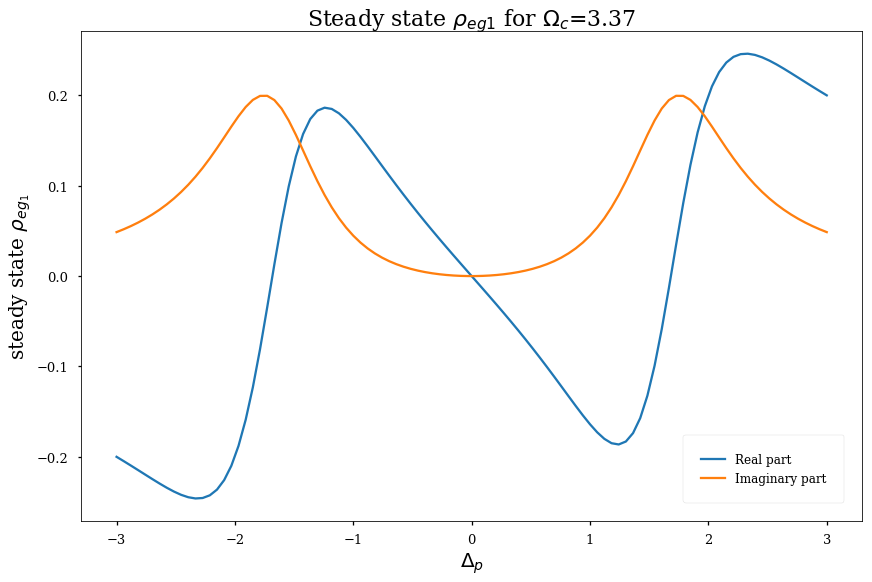

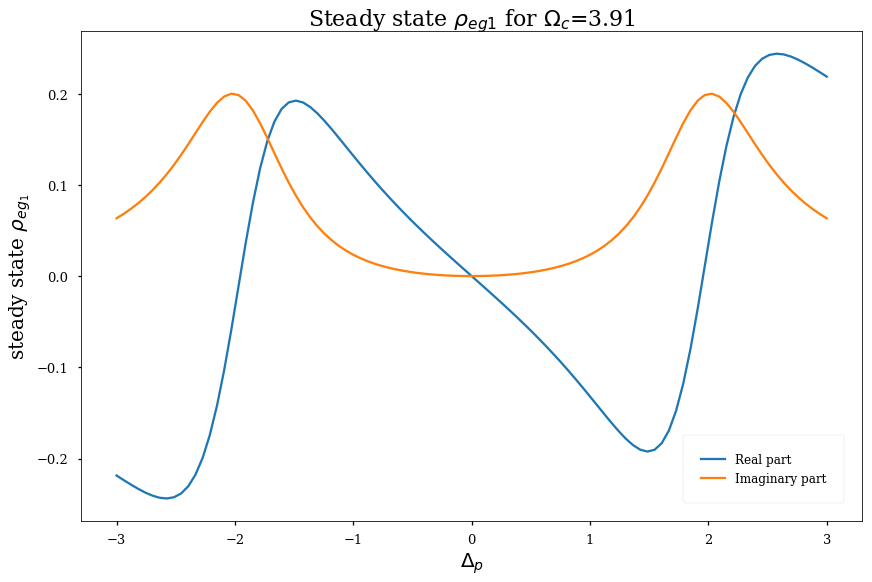

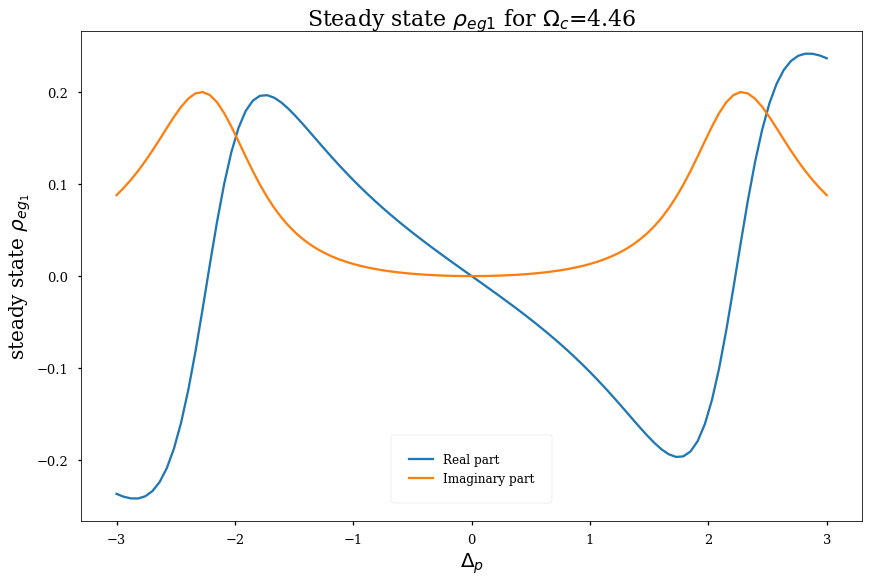

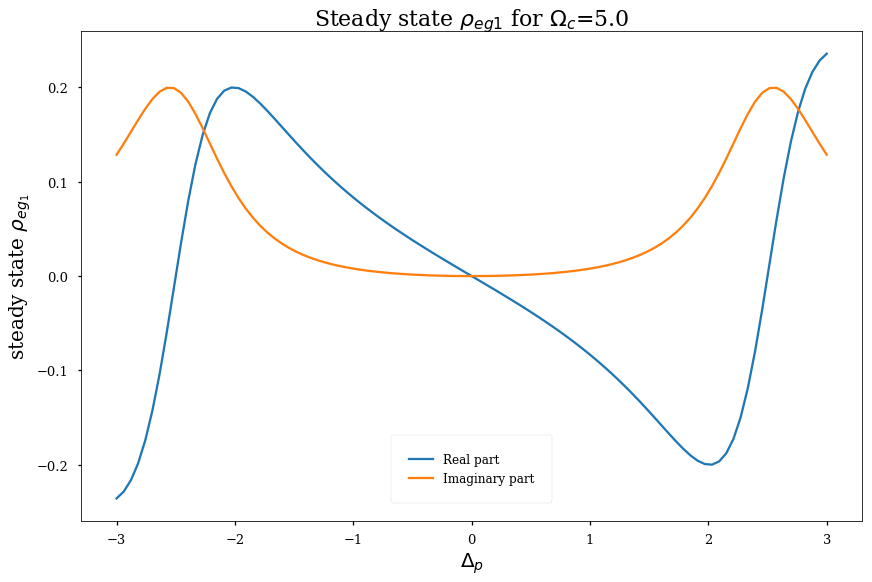

In [8]:
#Some test values for the coupling Rabi frequency
Omega_c = np.linspace(0.1,5,10)

for omega_c in Omega_c:
    steady_real = []
    steady_imag = []
    for value in Delta_p:
        L = Liouvillian(buildHmat(Omega_p, omega_c, value, Delta_c), buildJumpOps(gamma_p, gamma_c, gamma_g))
        #eg1 component of the steady state
        steady = steady_state(L)[6] 
        steady_real.append(steady.real)
        steady_imag.append(steady.imag)
    #Plotting the results
    plt.plot(Delta_p, steady_real, label = 'Real part')
    plt.plot(Delta_p, steady_imag, label = 'Imaginary part')
    plt.title(r'Steady state $\rho_{eg1}$ for ' + r'$ \Omega_c$={}'.format(round(omega_c,2)), size = 22)
    plt.xlabel(r'$\Delta_p$', size = 20)
    plt.ylabel(r'steady state $\rho_{eg_1}$', size = 20)
    plt.legend(frameon=True,fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')
    plt.show()
    plt.close()

### Interpretation:
For larger values of $\Omega_c$ one definitely sees that the characteristc form, especially the peaks, widen a lot and the it is harder and less precise to analyse the plot. Changing the Rabi frequency of the coupling laser therefore only changes the spectral profile of absorption This is what we would epect, according to figure 7 in the paper!

### Varying $\gamma_c$

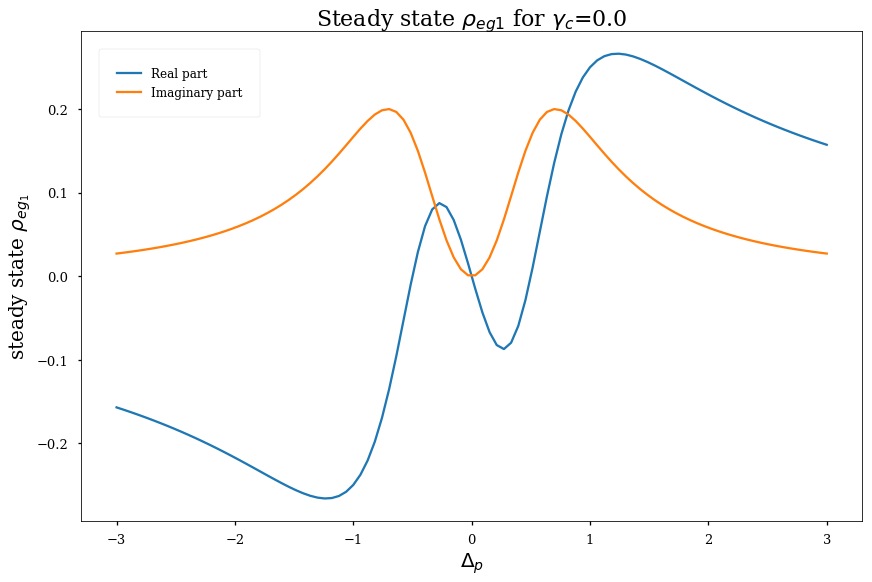

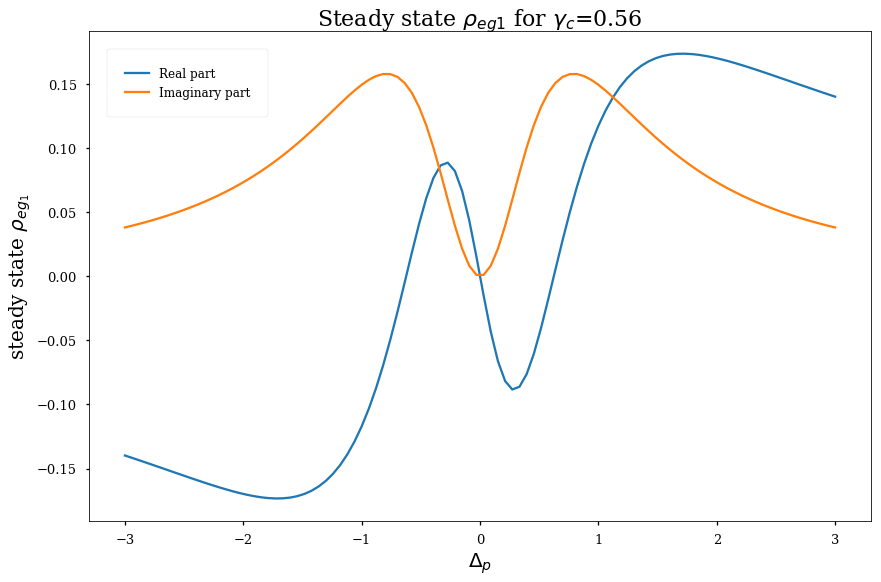

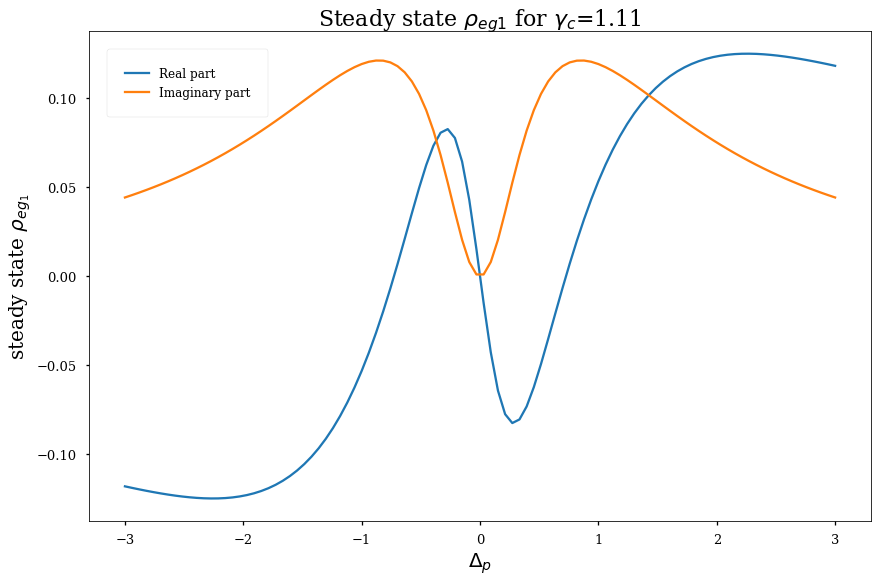

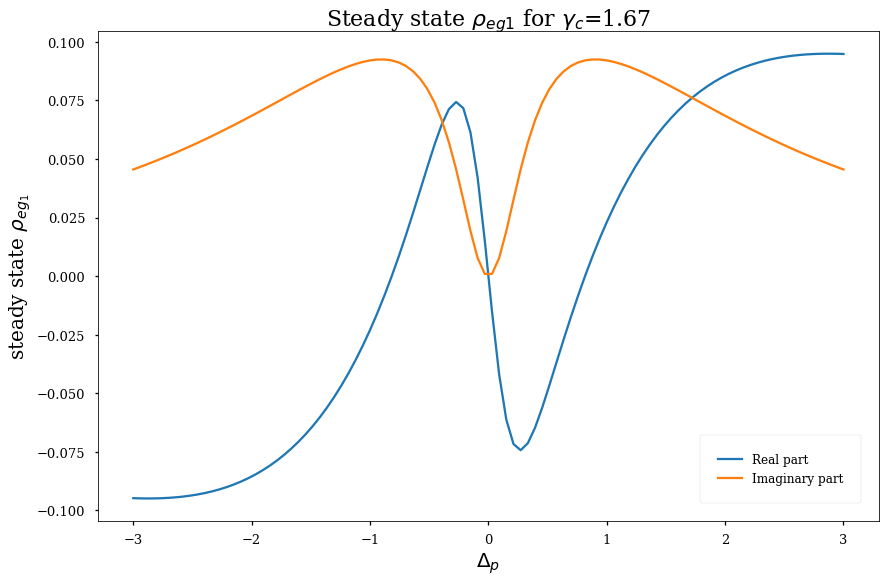

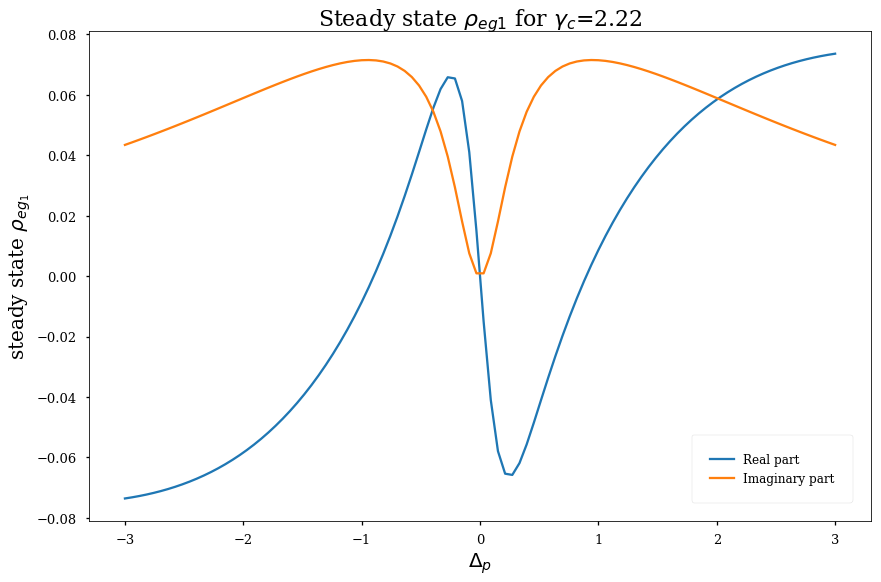

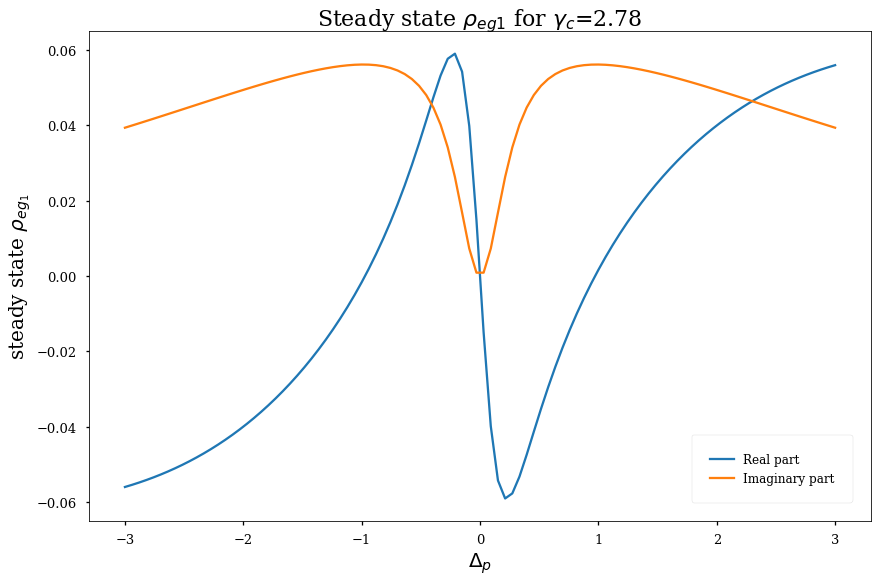

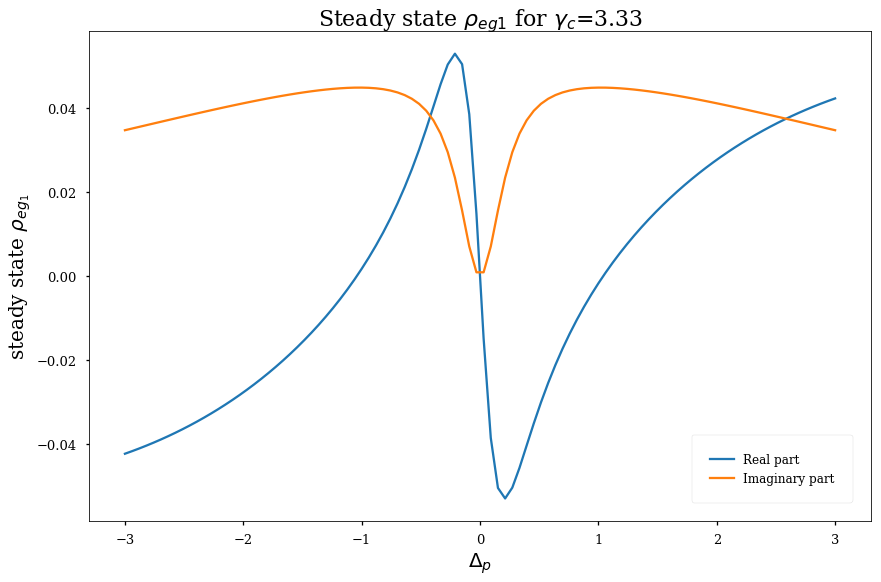

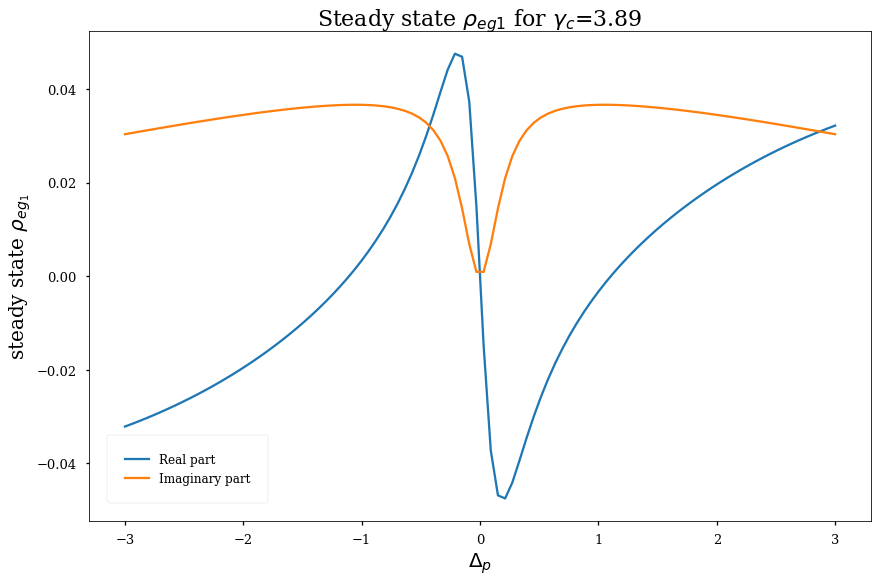

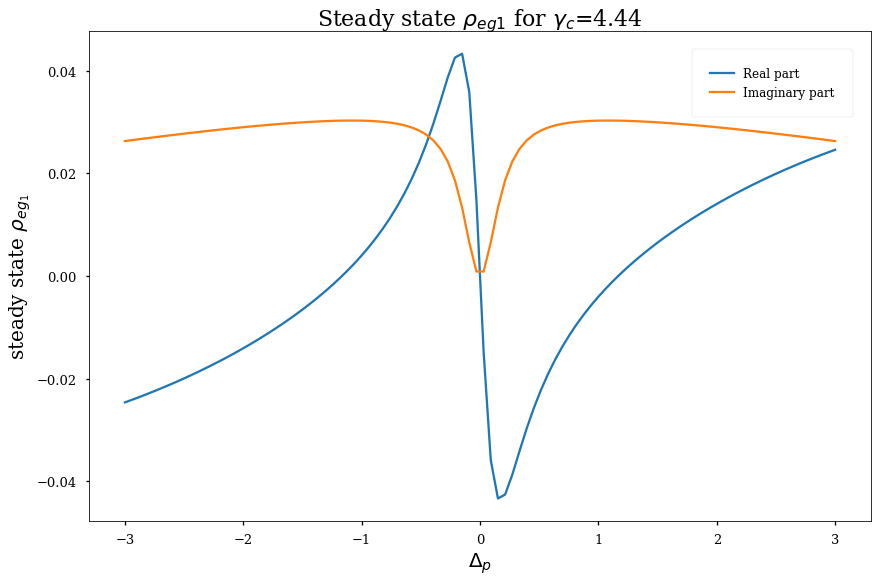

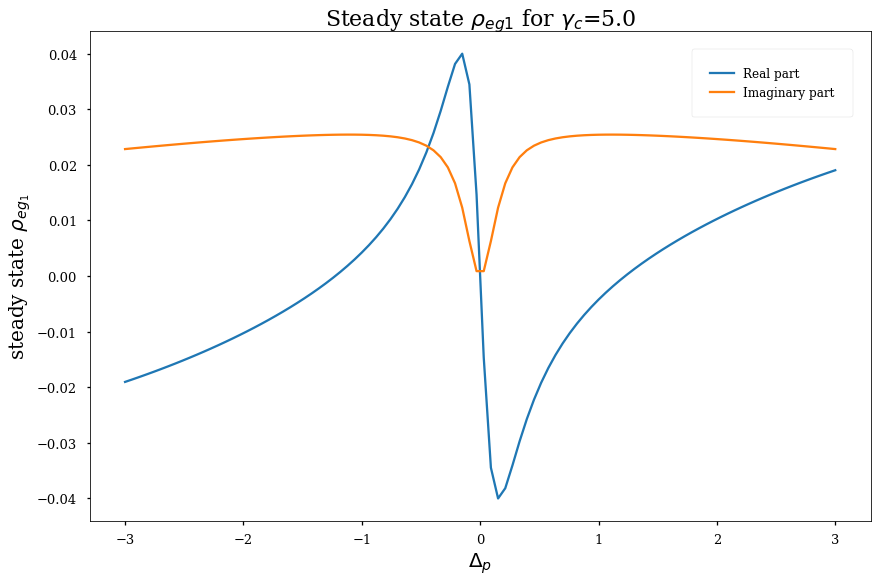

In [9]:
#Some test values for gamma_c
gamma_c = np.linspace(0,5,10)

for gamma in gamma_c:
    steady_real = []
    steady_imag = []
    for value in Delta_p:
        L = Liouvillian(buildHmat(Omega_p, 1, value, Delta_c), buildJumpOps(gamma_p, gamma, gamma_g))
        #eg1 component of the steady state
        steady = steady_state(L)[6] 
        steady_real.append(steady.real)
        steady_imag.append(steady.imag)
    #Plotting the results
    plt.plot(Delta_p, steady_real, label='Real part')
    plt.plot(Delta_p, steady_imag, label='Imaginary part')
    plt.title(r'Steady state $\rho_{eg1}$ for ' + r'$ \gamma_c$={}'.format(round(gamma,2)), size = 22)
    plt.xlabel(r'$\Delta_p$', size = 20)
    plt.ylabel(r'steady state $\rho_{eg_1}$', size = 20)
    plt.legend(frameon=True,fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')
    plt.show()
    plt.close()

### Interpretation:

By varying $\gamma_c$ we see that the observed peaks in the real und imaginary part get a lot steeper.

### Exercise 3 (10 points)

Now add a spontaneous decay from $g_2$ to $g_1$. Make the same plots as in Exercise 2 for a fixed value of in $\Omega_c=2\gamma$ and various values of $\gamma_{g}$. What do you observe? Compare to Fig. 10 in [1].

### Solution:

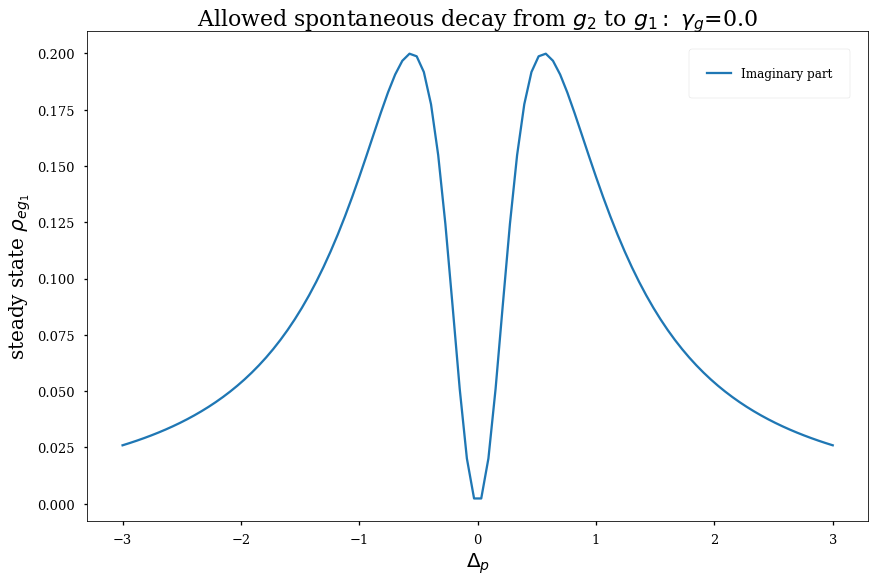

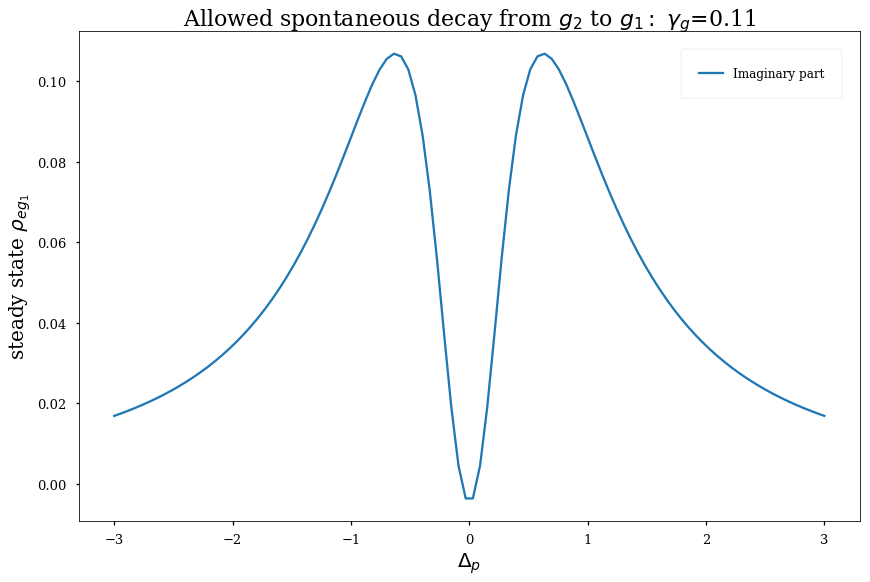

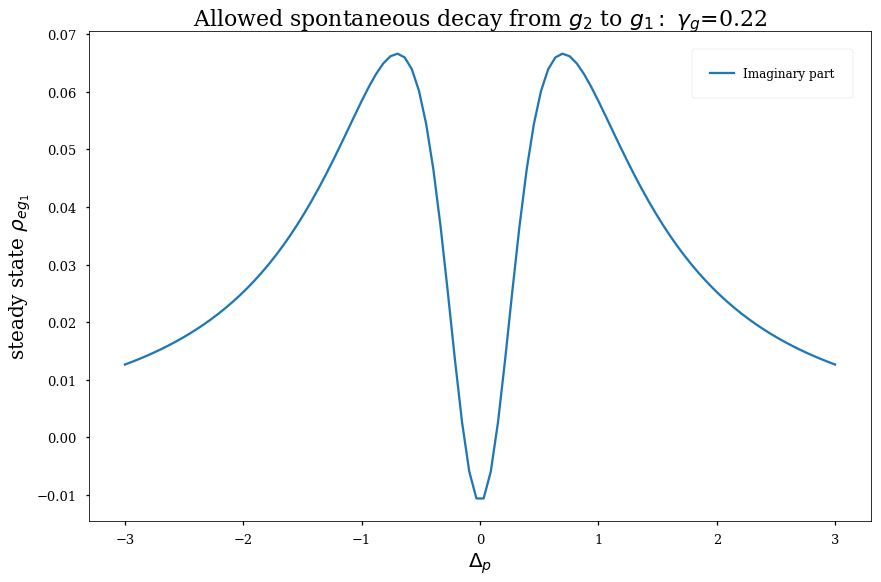

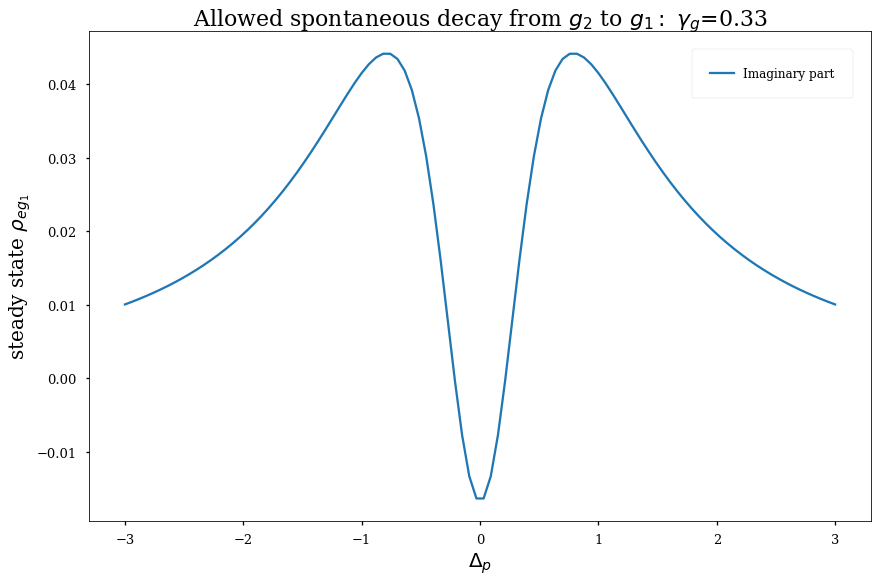

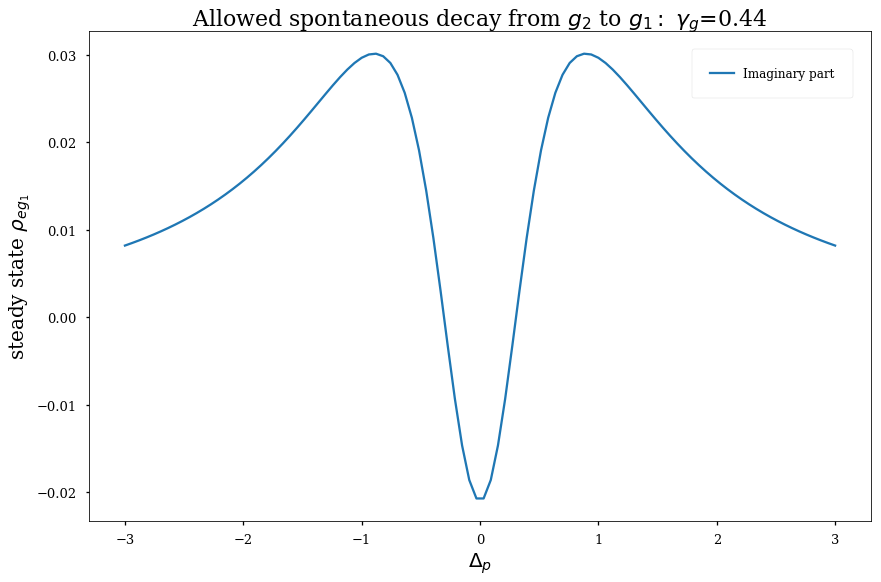

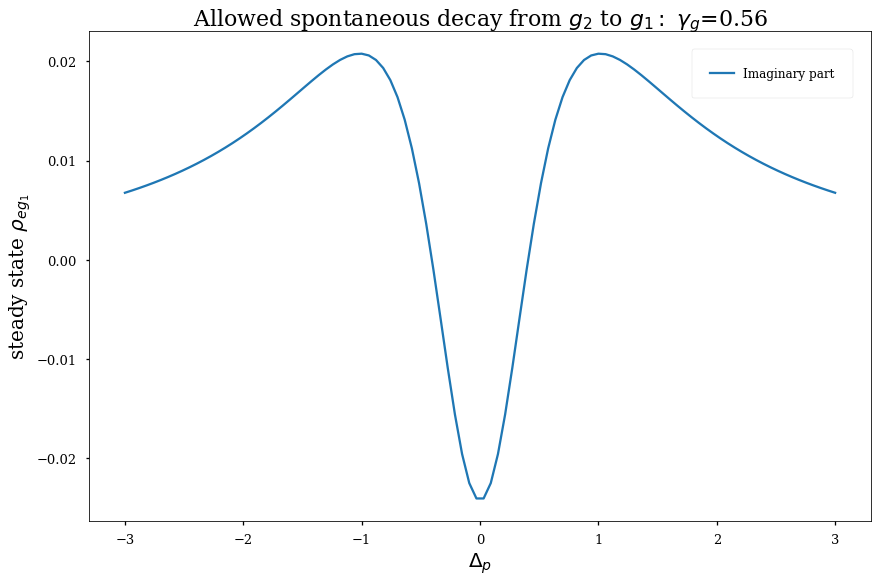

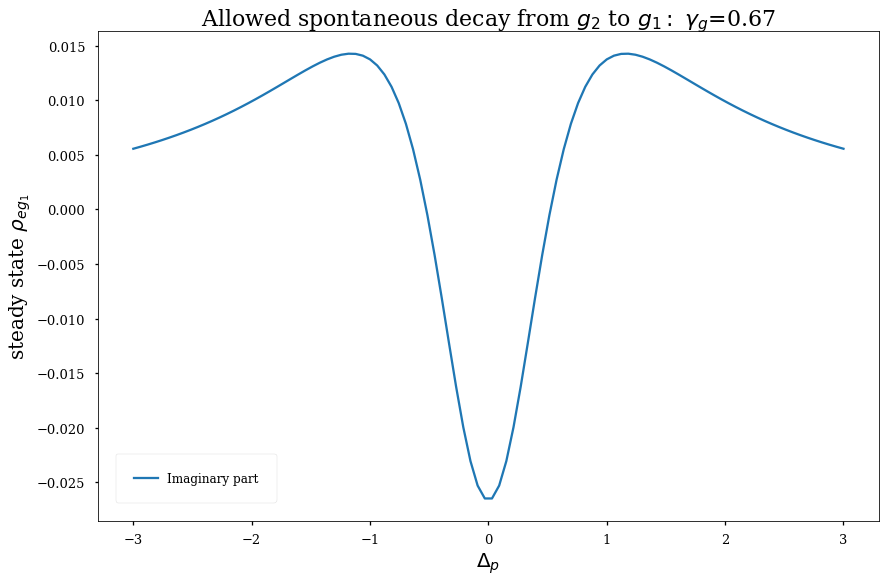

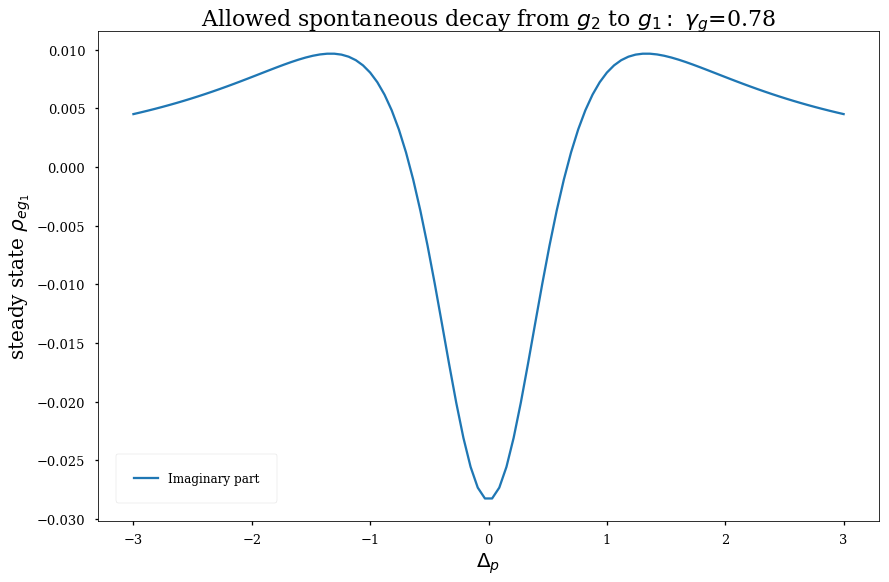

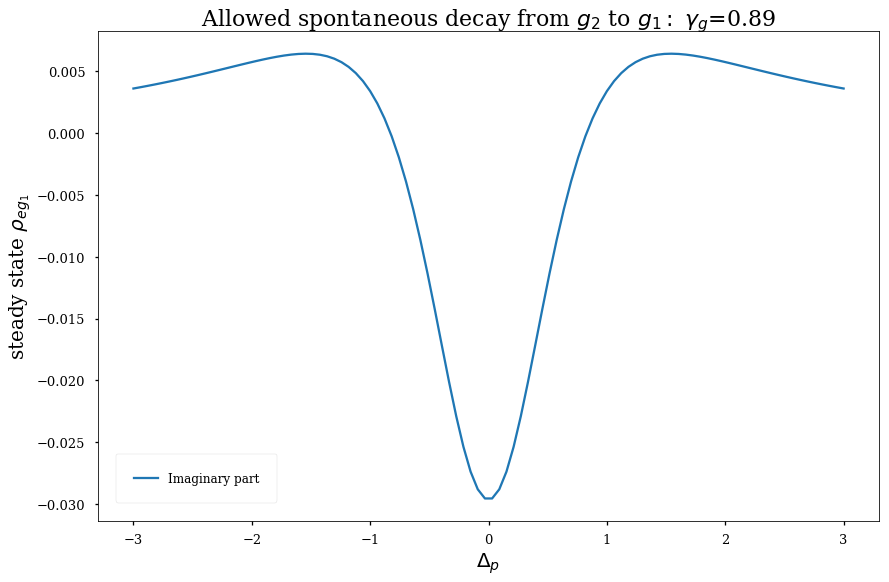

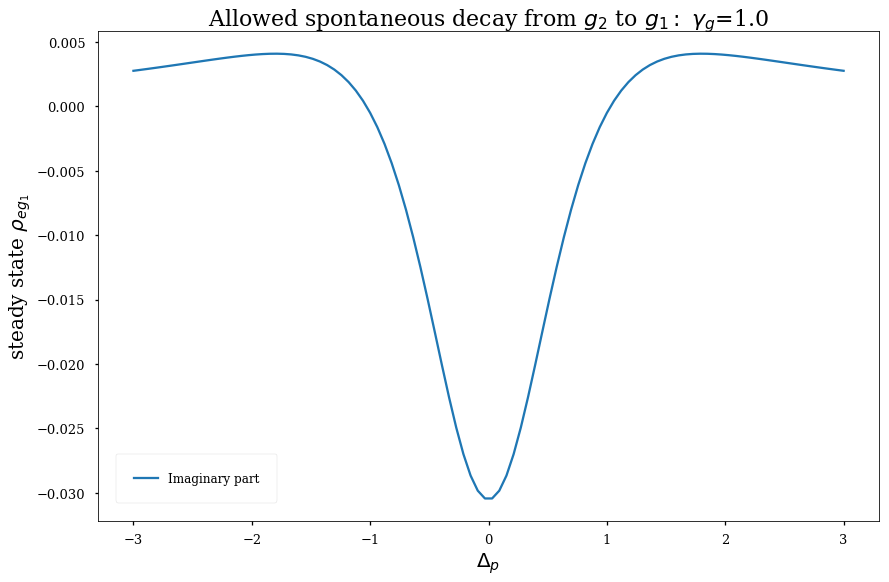

In [10]:
#Some parameters
(Delta_p, Delta_c) = (np.linspace(-3,3,100), 0)
(Omega_c, Omega_p, gamma_p, gamma_c, gamma_g) = (0.5, 1, 1, 0, np.linspace(0,1,10))

for gamma in gamma_g:
    steady_real = []
    steady_imag = []
    for value in Delta_p:
        L = Liouvillian(buildHmat(Omega_p, Omega_c, value, Delta_c), buildJumpOps(gamma_p, gamma_c, gamma))
        #eg1 component of the steady state
        steady = steady_state(L)[6]
        steady_real.append(steady.real)
        steady_imag.append(steady.imag)
    #Plotting the results
    #plt.plot(Delta_p, steady_real)
    plt.plot(Delta_p, steady_imag, label = 'Imaginary part')
    plt.title(r'Allowed spontaneous decay from $g_2$ to $g_1: $ ' + r'$ \gamma_g$={}'.format(round(gamma,2)), size = 22)
    plt.xlabel(r'$\Delta_p$', size = 20)
    plt.ylabel(r'steady state $\rho_{eg_1}$', size = 20)
    plt.legend(frameon=True,fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')
    plt.show()
    plt.close()

### Interpretation:

Normally we would expect that the gap closes as seen in Fig. 10 in the paper. We are not really sure why this is not true in our case and why the values get negative. Maybe we misunderstood something..

### Exercise 4 (30 points)

Dynamics: Solve the Master equation time-dependently with initial state $\rho_0 = |g_1\rangle \langle g_1|$. You can use a scipy intergrator, for example the one used on exercise sheet 5. Plot the populations of the levels and the real and imaginary part of $\rho_{eg_1}$ as a function of time. Good example parameters are $\Omega_p = 1, \Omega_c = \gamma_p = 2$ and the others zero, integrating to t=10. Check qualitatively how the time for approaching the steady state depends on the parameters, especially on $\Omega_c$ and $\gamma_p$.

### Solution:

In [11]:
#To solve the ODE
from scipy.integrate import ode

#Defining the initial state
initial_state = np.reshape(np.outer(states['g1'], states['g1']), 9)
dt = 0.01

#Calculating the time evolution by solving the master equation
def solving_ME(Omega_p = 1, Omega_c = 2, gamma_p = 2, tend = 10):
    (gamma_c, gamma_g, Delta_p, Delta_c) = np.zeros(4)

    Hamiltonian = buildHmat(Omega_p, Omega_c, Delta_p, Delta_c)
    JumpOperators = buildJumpOps(gamma_p, gamma_c, gamma_g)

    def MasterEquation(t, rho):
        return MasterEqn(rho, Hamiltonian, JumpOperators)

    integrator = ode(MasterEquation).set_integrator('zvode', method = 'adams')
    integrator.set_initial_value(initial_state, 0)

    tsteps = int(np.round(tend/dt))
    tvec = np.linspace(0, dt*tsteps, tsteps + 1)

    result = np.zeros((tsteps + 1, 9), dtype = complex)
    result[0] = initial_state

    for i in range(1, tsteps+1):
        result[i] = integrator.integrate(integrator.t + dt)
        
    return result

tsteps = int(np.round(10/dt))
tvec = np.linspace(0, dt*tsteps, tsteps + 1)
result = solving_ME()

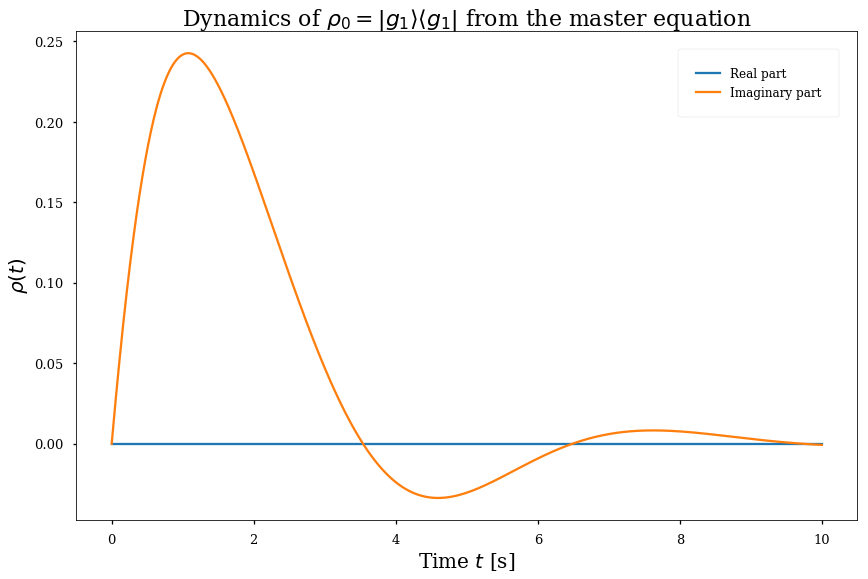

In [12]:
#Plotting the result
plt.plot(tvec, result[:, 6].real, label = 'Real part')
plt.plot(tvec, result[:, 6].imag, label = 'Imaginary part')
plt.title(r'Dynamics of $\rho_0 = |g_1\rangle\langle g_1|$ from the master equation', size=22)
plt.xlabel(r'Time $t$ [s]', size = 20)
plt.ylabel(r'$\rho(t)$', size = 20)
plt.legend(frameon=True,fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')

In [13]:
#Calculating the population of the different eigenstates
populations = np.zeros((tsteps + 1, 3), dtype = complex)
for i in range(0, tsteps+1):
    populations[i] = LA.eig(np.reshape(result[i], (3,3)))[0]
    
print(populations[0])

[ 1.+0.j  0.+0.j  0.+0.j]


No handles with labels found to put in legend.


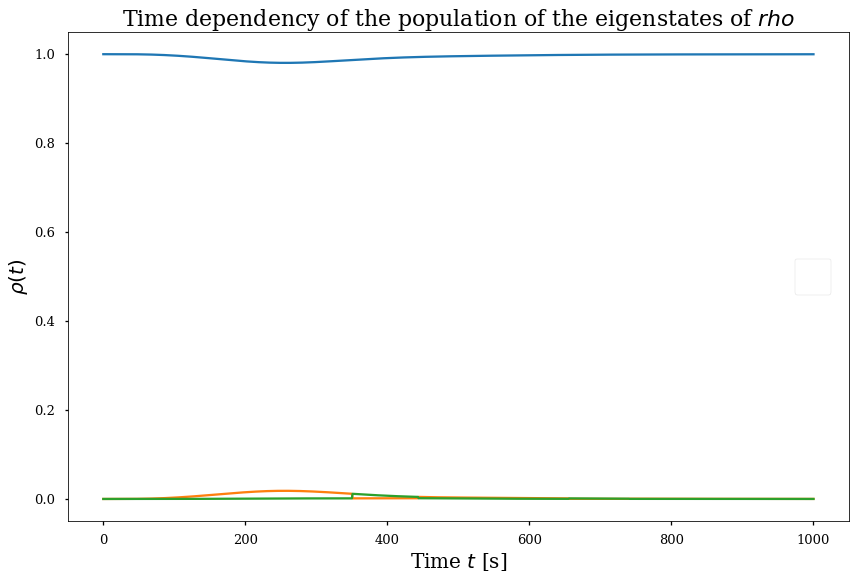

In [14]:
#Plotting the results
plt.plot(populations.real)
plt.title(r'Time dependency of the population of the eigenstates of $rho$', size=22)
plt.xlabel(r'Time $t$ [s]', size = 20)
plt.ylabel(r'$\rho(t)$', size = 20)
plt.legend(frameon=True,fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')

### Discussion:

As one can easily see in the plot above, the population of the different states is not time dependent.

### Parameter dependency of the time to reach the steady state

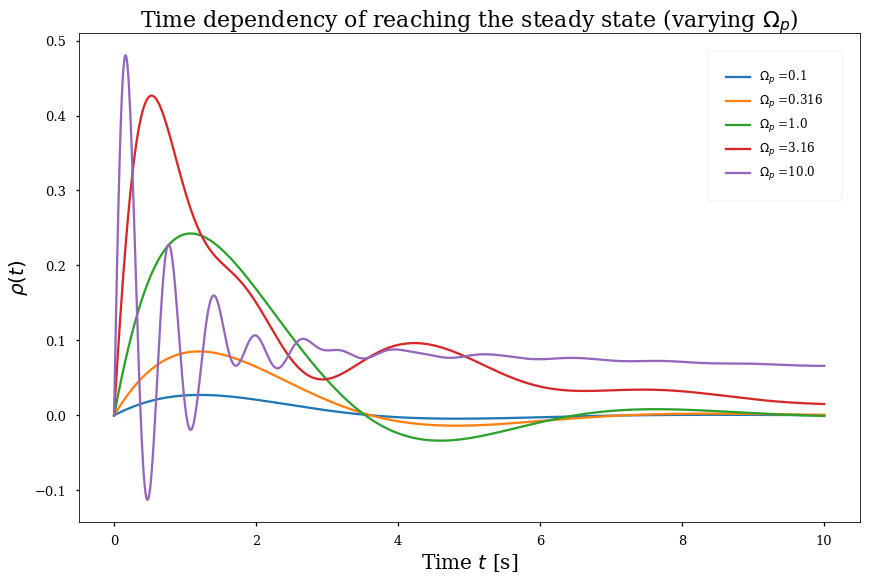

In [15]:
tsteps = int(np.round(10/dt))
tvec = np.linspace(0, dt*tsteps, tsteps + 1)

#Some test values for Omega_p
Omega_p_vec = np.logspace(-1, 1, 5)
for value in Omega_p_vec:
    result = solving_ME(Omega_p = value, tend = 10)
    plt.plot(tvec, result[:, 6].imag, label = '$\Omega_p$ ={:.3}'.format(value))
    plt.title(r'Time dependency of reaching the steady state (varying $\Omega_p$)', size=22)
    plt.xlabel(r'Time $t$ [s]', size = 20)
    plt.ylabel(r'$\rho(t)$', size = 20)
    plt.legend(frameon=True,fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')

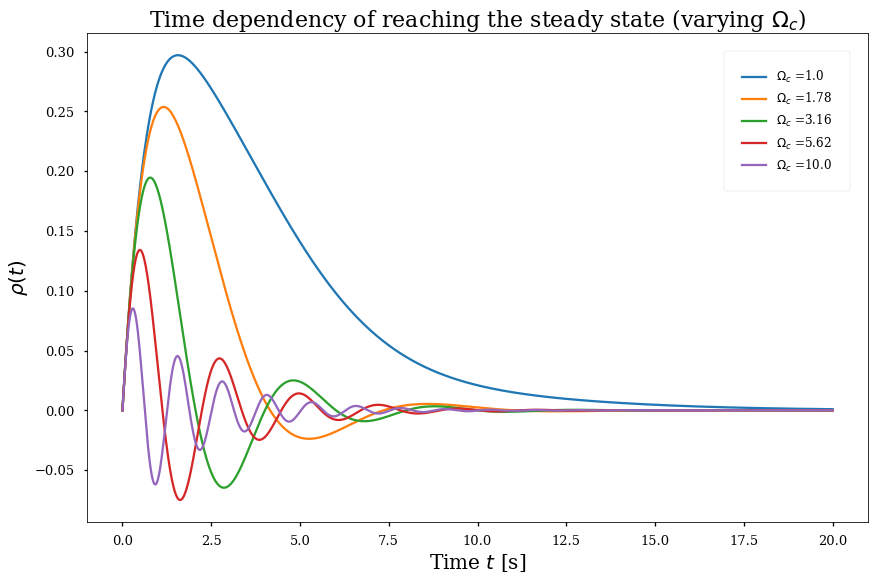

In [16]:
tsteps = int(np.round(20/dt))
tvec = np.linspace(0, dt*tsteps, tsteps + 1)

Omega_c_vec = np.logspace(0, 1, 5)
for value in Omega_c_vec:
    result = solving_ME(Omega_c = value, tend = 20)
    plt.plot(tvec, result[:, 6].imag, label = '$\Omega_c$ ={:.3}'.format(value))
    plt.title(r'Time dependency of reaching the steady state (varying $\Omega_c$)', size=22)
    plt.xlabel(r'Time $t$ [s]', size = 20)
    plt.ylabel(r'$\rho(t)$', size = 20)
    plt.legend(frameon=True,fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')

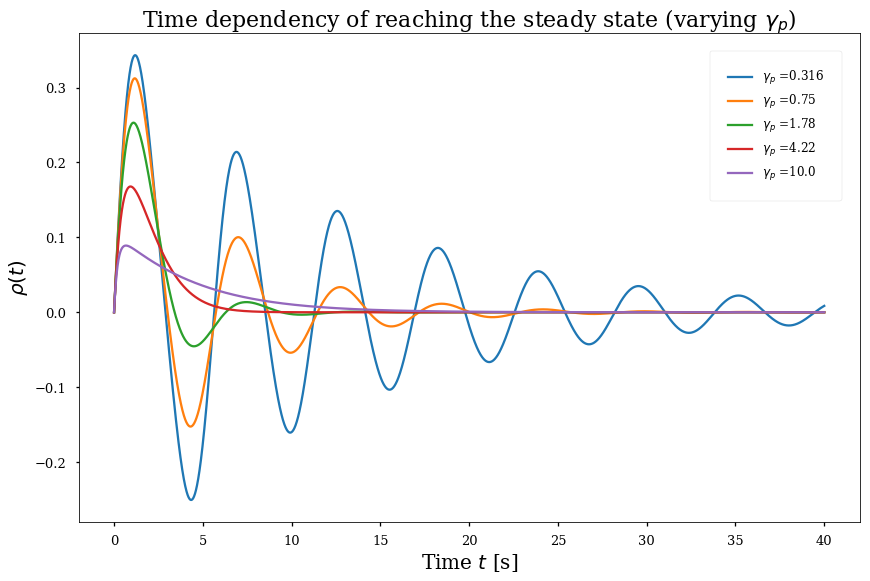

In [17]:
tsteps = int(np.round(40/dt))
tvec = np.linspace(0, dt*tsteps, tsteps + 1)

gamma_p_vec = np.logspace(-0.5, 1, 5)
for value in gamma_p_vec:
    result = solving_ME(gamma_p = value, tend = 40)
    plt.plot(tvec, result[:, 6].imag, label = '$\gamma_p$ ={:.3}'.format(value))
    plt.title(r'Time dependency of reaching the steady state (varying $\gamma_p$)', size=22)
    plt.xlabel(r'Time $t$ [s]', size = 20)
    plt.ylabel(r'$\rho(t)$', size = 20)
    plt.legend(frameon=True,fontsize='large', borderpad=1.5, borderaxespad=1.5,loc='best')

In [18]:
#Trying to find a functional connection
def steady_time(Omega_p = 1, Omega_c = 2, gamma_p = 2, tend = 10):
    result = solving_ME(Omega_p, Omega_c, gamma_p, tend)
    slope = result[1:] - result[:-1]
    
    tsteps = int(np.round(tend/dt))
    tvec = np.linspace(0, dt*tsteps, tsteps + 1)
    
    #relevant data is the imaginary part of rho[6]
    res = result[:-1, 6].imag #neglecting the last value in order to get len(res)==len(slo)
    slo = slope[:, 6].imag
    condition = (np.abs(res) < 0.005 * max(np.abs(res))) & (np.abs(slo) < 0.005 * max(np.abs(slo)))
    
    time = max(np.arange(len(condition))[condition == False]) + 1
    if (time != len(res) and condition[time]):
        return tvec[time]
    else:
        print('tend has been increased')
        return steady_time(Omega_p, Omega_c, gamma_p, tend * 2)

Text(0.5, 0, '$\\gamma_p$')

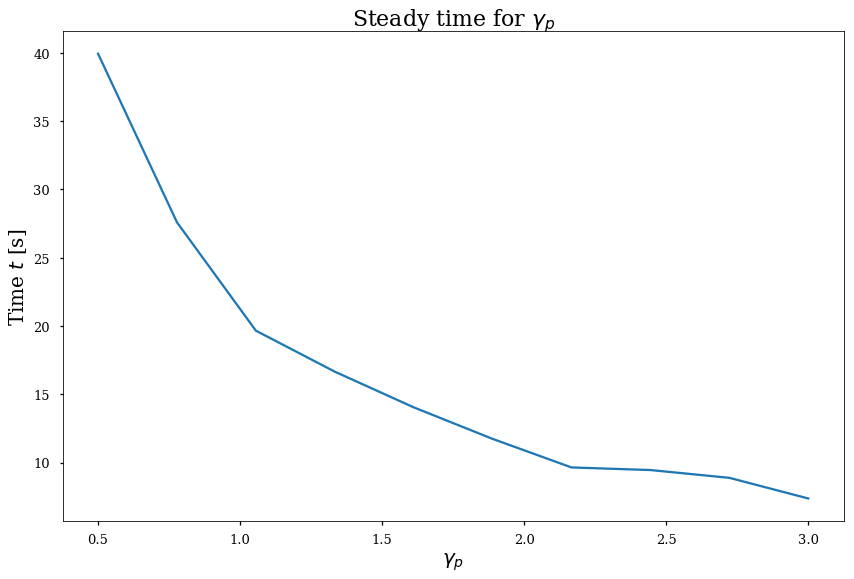

In [24]:
gamma_p_vec = np.linspace(0.5, 2.5+.5, 10)
time2 = [steady_time(gamma_p = value, tend = 40) for value in gamma_p_vec]
plt.plot(gamma_p_vec, time2)
plt.title(r'Steady time for $\gamma_p$', size=22)
plt.ylabel(r'Time $t$ [s]', size = 20)
plt.xlabel(r'$\gamma_p$', size = 20)

tend has been increased
tend has been increased


Text(0.5, 0, '$\\Omega_p$')

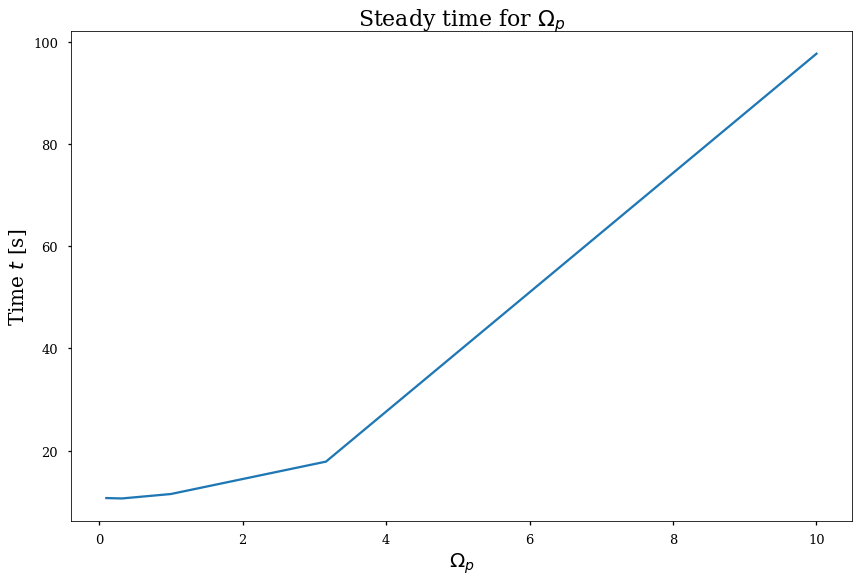

In [23]:
Omega_p_vec = np.logspace(-1, 1, 5)
time2 = [steady_time(Omega_p = value, tend = 40) for value in Omega_p_vec]
plt.plot(Omega_p_vec, time2)
plt.title(r'Steady time for $\Omega_p$', size=22)
plt.ylabel(r'Time $t$ [s]', size = 20)
plt.xlabel(r'$\Omega_p$', size = 20)

Text(0.5, 0, '$\\Omega_c$')

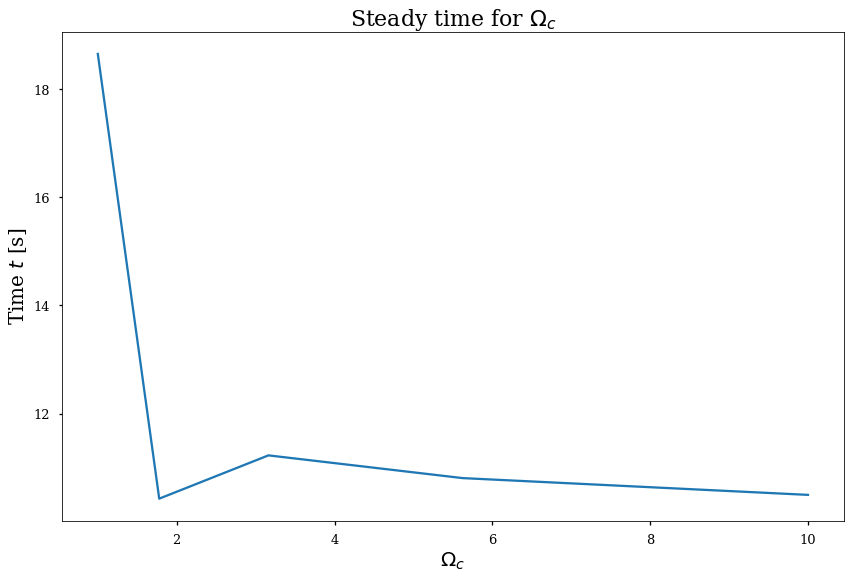

In [22]:
Omega_c_vec = np.logspace(0, 1, 5)
time2 = [steady_time(Omega_c = value, tend = 40) for value in Omega_c_vec]
plt.plot(Omega_c_vec, time2)
plt.title(r'Steady time for $\Omega_c$', size=22)
plt.ylabel(r'Time $t$ [s]', size = 20)
plt.xlabel(r'$\Omega_c$', size = 20)

### Discussion:

As one can see, the time for reaching the steady state depends a lot on the choice of parameters. We could not explain why in the first part of this exercise the real part of the time evolution was alsways zero.. maybe we did something wrong..